In [3]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import sklearn.metrics as mt
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import RFE
#import warnings
#warnings.filterwarnings('ignore')
from sklearn.ensemble import RandomForestClassifier



In [2]:
# import 2018Q2 data

data_q1=pd.read_csv('LoanStats_2016Q1.csv',skiprows=1,header=0) #2016Q1
data_q2=pd.read_csv('LoanStats_2016Q2.csv',skiprows=1,header=0) #2016Q2
data_q3=pd.read_csv('LoanStats_2016Q3.csv',skiprows=1,header=0) #2016Q3
data_q4=pd.read_csv('LoanStats_2016Q4.csv',skiprows=1,header=0) #2016Q4

frames = [data_q1, data_q2, data_q3, data_q4]

data_df = pd.concat(frames,sort=True)

/Users/drawing/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/Users/drawing/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (0,19,59) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
data_df.head()

,acc_now_delinq,acc_open_past_24mths,addr_state,all_util,annual_inc,annual_inc_joint,application_type,avg_cur_bal,bc_open_to_buy,bc_util,...,total_pymnt,total_pymnt_inv,total_rec_int,total_rec_late_fee,total_rec_prncp,total_rev_hi_lim,url,verification_status,verification_status_joint,zip_code
0,0.0,4.0,GA,86.0,66000.0,NaN,Individual,22436.0,585.0,90.6,...,9449.400972,9449.40,1049.40,0.0,8400.00,14100.0,https://lendingclub.com/browse/loanDetail.acti...,Not Verified,NaN,301xx
1,0.0,5.0,OH,40.0,45000.0,NaN,Individual,2664.0,33197.0,40.4,...,11252.380000,11252.38,1453.93,0.0,9798.45,60100.0,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,454xx
2,0.0,0.0,TX,34.0,60000.0,NaN,Individual,4846.0,32803.0,34.4,...,26064.110000,26064.11,3170.52,0.0,22893.59,50000.0,https://lendingclub.com/browse/loanDetail.acti...,Verified,NaN,750xx
3,0.0,1.0,FL,50.0,70000.0,NaN,Individual,6764.0,9343.0,16.1,...,10190.210000,10190.21,2152.14,0.0,8038.07,11400.0,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,331xx
4,0.0,0.0,FL,89.0,49000.0,NaN,Individual,15740.0,481.0,96.3,...,23693.642605,23693.64,3693.64,0.0,20000.00,21200.0,https://lendingclub.com/browse/loanDetail.acti...,Source Verified,NaN,321xx


In [4]:
def Preprocess_Data(data_df,save_mod):
    # drop irrelevant predictors such as id and url (also description because we do not plan to do text mining)
    data1=data_df.drop(['member_id','id','desc','url'], axis=1)
    
    # Keep only 'Fully Paid' or 'Charged Off'
    # The reason for doing this early is to save some memory 
    data1= data1[(data1["loan_status"] == "Fully Paid") | (data1["loan_status"] == "Charged Off")]
 
    # drop columns that contain missing values more than 1% of the rows
    col=data1.columns
    Na_in_col = pd.isnull(data1).sum()
    for i in range(len(col)):
        if Na_in_col[i] > data1.shape[0]*0.01:
            data1=data1.drop(col[i], axis=1)
            
    col=data1.columns # renew 
    
    # drop columns that may leak information     
    drop_leak = ['funded_amnt','funded_amnt_inv','issue_d','out_prncp','out_prncp_inv',
                 'total_pymnt','total_pymnt_inv','total_rec_prncp','total_rec_int', 'total_rec_late_fee',
                 'recoveries', 'collection_recovery_fee', 'last_pymnt_d','last_pymnt_amnt',
                 'last_fico_range_high','last_fico_range_low'
                ]
    for column in drop_leak:
        if column in col:
            data1 = data1.drop(column,axis=1)

    # drop columns that contain redundant information
    drop_redundant = ['sub_grade', 'int_rate','zip_code','title']
    for column in drop_redundant:
        if column in col:
            data1 = data1.drop(column,axis=1)
    
    
    # drop columns that require too much preprocessing to become a valid predictors
    drop_troublesome = ['emp_title','earliest_cr_line','initial_list_status',
                        'addr_state','last_credit_pull_d']
    for column in drop_troublesome:
        if column in col:
            data1 = data1.drop(column,axis=1)
    
    # drop columns with only one value
    data1= data1.loc[:,data1.apply(pd.Series.nunique) != 1]
    
    
    #Again, there may be some columns with more than one unique values 
    #but one of the values has insignificant frequency in the dataset. Let's find out and drop such column(s)
    for col in data1.columns:
        if (len(data1[col].unique()) < 4):
            tmp = data1[col].value_counts() 
            tmp = tmp/sum(tmp) # convert each counts into percentage
            if sum(tmp > 0.95) >= 1: # if there is 1 values that predominant (more than 95%)
                data1 = data1.drop(col, axis=1)

    mapping_dictionary = {"loan_status":{ "Fully Paid": 1, "Charged Off": 0}}
    data1= data1.replace(mapping_dictionary)
                
   # Drop rows that contain NA
    data1 = data1.dropna()
            
   # Format revol_util (remove % and change into float)
    if 'revol_util' in data1.columns:
        data1['revol_util'] = data1['revol_util'].str.rstrip('%').astype('float')
        
    # Convert ordinary data 
    mapping_dict = {
        "grade":{
            "A": 1,
            "B": 2,
            "C": 3,
            "D": 4,
            "E": 5,
            "F": 6,
            "G": 7
        }
    }

    data1 = data1.replace(mapping_dict)
    
    
    
    # Convert categorical columns using one-hot-coding
    nominal_columns = ['home_ownership', 'verification_status', 'purpose', 
                       'term', 'disbursement_method', 'application_type']
    for col in nominal_columns:
        if col in data1.columns:
            dummy_df = pd.get_dummies(data1[col])
            data1 = pd.concat([data1, dummy_df], axis=1)
            data1 = data1.drop(col, axis=1)
   
    # new feature 
    data1['installment_feat'] = data1['installment'] / (data1['annual_inc'] / 12)
    
    if save_mod:
        #save clean data
        data1.to_csv("data_cleaned_shujian.csv",index=False)
    
    return  data1

In [5]:
temp = Preprocess_Data(data_df, save_mod = True)

In [6]:
# Some checks to make sure no error in above code 

# How many columns are still object
object_columns_df = temp.select_dtypes(include=['object'])
print (object_columns_df.shape) # should be (xxxx, 0)
# How many NA are still in the data
print (sum(pd.isnull(temp).sum())) # should equal to 0

print ('Number of columns:',len(temp.columns))

(226894, 0)
0
Number of columns: 83


In [7]:
info = temp.info() # will output each columns info 
#debt_settlement_flag

<class 'pandas.core.frame.DataFrame'>
Int64Index: 226894 entries, 0 to 103544
Data columns (total 83 columns):
acc_now_delinq                226894 non-null float64
acc_open_past_24mths          226894 non-null float64
all_util                      226894 non-null float64
annual_inc                    226894 non-null float64
avg_cur_bal                   226894 non-null float64
chargeoff_within_12_mths      226894 non-null float64
collections_12_mths_ex_med    226894 non-null float64
delinq_2yrs                   226894 non-null float64
delinq_amnt                   226894 non-null float64
dti                           226894 non-null float64
fico_range_high               226894 non-null float64
fico_range_low                226894 non-null float64
grade                         226894 non-null int64
inq_fi                        226894 non-null float64
inq_last_12m                  226894 non-null float64
inq_last_6mths                226894 non-null float64
installment                

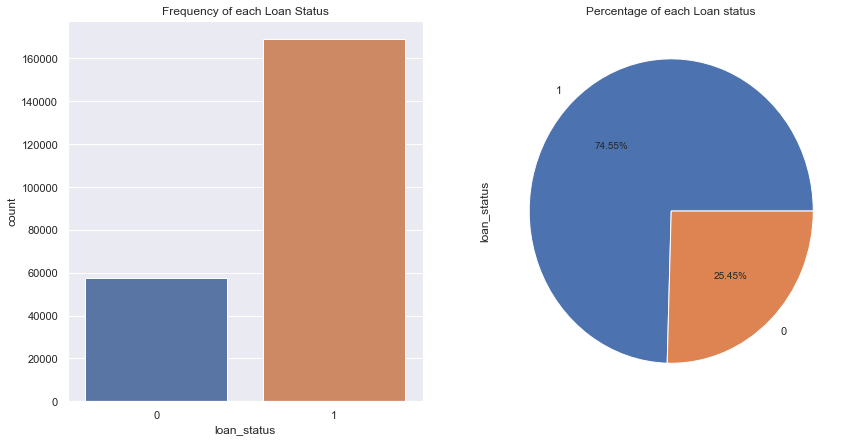

In [8]:
fig, axs = plt.subplots(1,2,figsize=(14,7))
sns.countplot(x='loan_status',data=temp,ax=axs[0])
axs[0].set_title("Frequency of each Loan Status")
temp.loan_status.value_counts().plot(x=None,y=None, kind='pie', ax=axs[1],autopct='%1.2f%%')
axs[1].set_title("Percentage of each Loan status")
plt.show()

In [9]:
# set y, X, split train 

y = temp["loan_status"]
X = temp.iloc[:, temp.columns != 'loan_status']

X_train, X_test, y_train, y_test = train_test_split (X, y, test_size=0.2, random_state=44)

# Standardize 
#std_scaler = StandardScaler()
std_scaler = MinMaxScaler() # tried, about the same results
col = X_train.select_dtypes(include=['float64',"int64"]).columns  # scale all or only foat give same results
X_train_S = X_train.copy()
X_test_S = X_test.copy()
X_train_S[col] = std_scaler.fit_transform(X_train_S[col])
X_test_S[col] = std_scaler.transform(X_test_S[col])
#X_train_S =std_scaler.fit_transform(X_train_S)
#X_test_S =std_scaler.transform(X_test_S)

/Users/drawing/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


In [10]:
# 1. multiple logistic regression(with all predictors)


#Training

model_logit = LogisticRegression(C=100000).fit(X_train_S, y_train)

#Predict
y_pred_train = model_logit.predict(X_train_S)
y_pred_test = model_logit.predict(X_test_S)

#Perfromance Evaluation
train_score = accuracy_score(y_train, y_pred_train)*100
test_score = accuracy_score(y_test, y_pred_test)*100

print("Training Set Accuracy:",str(train_score)+'%')
print("Test Set Accuracy:",str(test_score)+'%')
pd.crosstab(y_train,y_pred_train, margins=True, rownames=['Actual'], colnames=['Predicted'])



/Users/drawing/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training Set Accuracy: 75.47916150180426%
Test Set Accuracy: 75.61867824324027%


Predicted,0,1,All
Actual,,,
0,7392,38893,46285
1,5616,129614,135230
All,13008,168507,181515


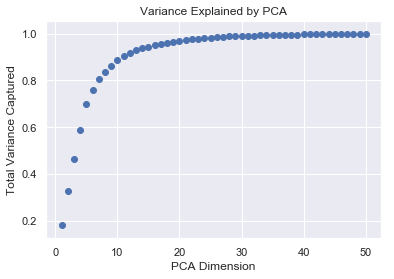

In [11]:
# PCA analysis 

number = min(len(X_train_S),50)
pca_all_transformer = PCA(number).fit(X_train_S)
x_train_2d = pca_all_transformer.transform(X_train_S)
plt.scatter(range(1,number+1),np.cumsum(pca_all_transformer.explained_variance_ratio_))
plt.xlabel("PCA Dimension")
plt.ylabel("Total Variance Captured")
plt.title("Variance Explained by PCA");

In [12]:
pca = PCA(.9)
pca.fit(X_train_S)
pca.n_components_ 

11

In [13]:
pca.n_components_

11

In [14]:
#I tried PCA first to reduce dimension, not improve performance and hard to explain
#Transforming x_train and x_test 
pca = PCA(n_components= 31)
pca.fit(X_train_S)
x_train_pca2 = pca.transform(X_train_S)
x_test_pca2 = pca.transform(X_test_S)

#Training
model6 = LogisticRegression(C=100000).fit(x_train_pca2, y_train)

#Predict
y_pred_train2 = model6.predict(x_train_pca2)
y_pred_test2 = model6.predict(x_test_pca2)

#Perfromance Evaluation
train_score = accuracy_score(y_train, y_pred_train2)*100
test_score = accuracy_score(y_test, y_pred_test2)*100

print("Training Set Accuracy:",str(train_score)+'%')
print("Testing Set Accuracy:",str(test_score)+'%')

/Users/drawing/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Training Set Accuracy: 75.23234994353083%
Testing Set Accuracy: 75.34983141981974%


In [15]:
## cross-val Logistic    (similar results, no need to run)

#Log_regression = LogisticRegressionCV(random_state=9001,penalty="l2",cv=5)
#Log_regression.fit(X_train_S,y_train)
#y_pred_train = Log_regression.predict(X_train_S)
#y_pred_test = Log_regression.predict(X_test_S)

#Perfromance Evaluation
#train_score = accuracy_score(y_train, y_pred_train)*100
#test_score = accuracy_score(y_test, y_pred_test)*100
    

#print("Training Set Accuracy:",str(train_score)+'%')
#print("Test Set Accuracy:",str(test_score)+'%')

In [16]:
# Use wrapper, Recursive Feature Elimination

#model_rfe = LogisticRegression(C=100000)
# 建立递归特征消除筛选器
#rfe = RFE(model_rfe, 5) #choose 30 variables
#rfe = rfe.fit(X_train_S, y_train)
# 打印筛选结果
#print(rfe.support_)
#print(rfe.ranking_) #ranking 为 1代表被选中，其他则未被代表未被选中
#col_filter = X_train_S.columns[rfe.support_] #通过布尔值筛选首次降维后的变量
#col_filter # 查看通过递归特征消除法筛选的变量

In [17]:
drop_col = ['installment', 'Source Verified', 'credit_card','RENT','tot_hi_cred_lim','total_il_high_credit_limit',' 36 months',
            "pct_tl_nvr_dlq",'mo_sin_rcnt_tl','mo_sin_rcnt_rev_tl_op',"OWN","num_actv_rev_tl","Verified","num_sats"]
X_train_S = X_train_S.drop(drop_col,axis = 1) #剔除冗余特

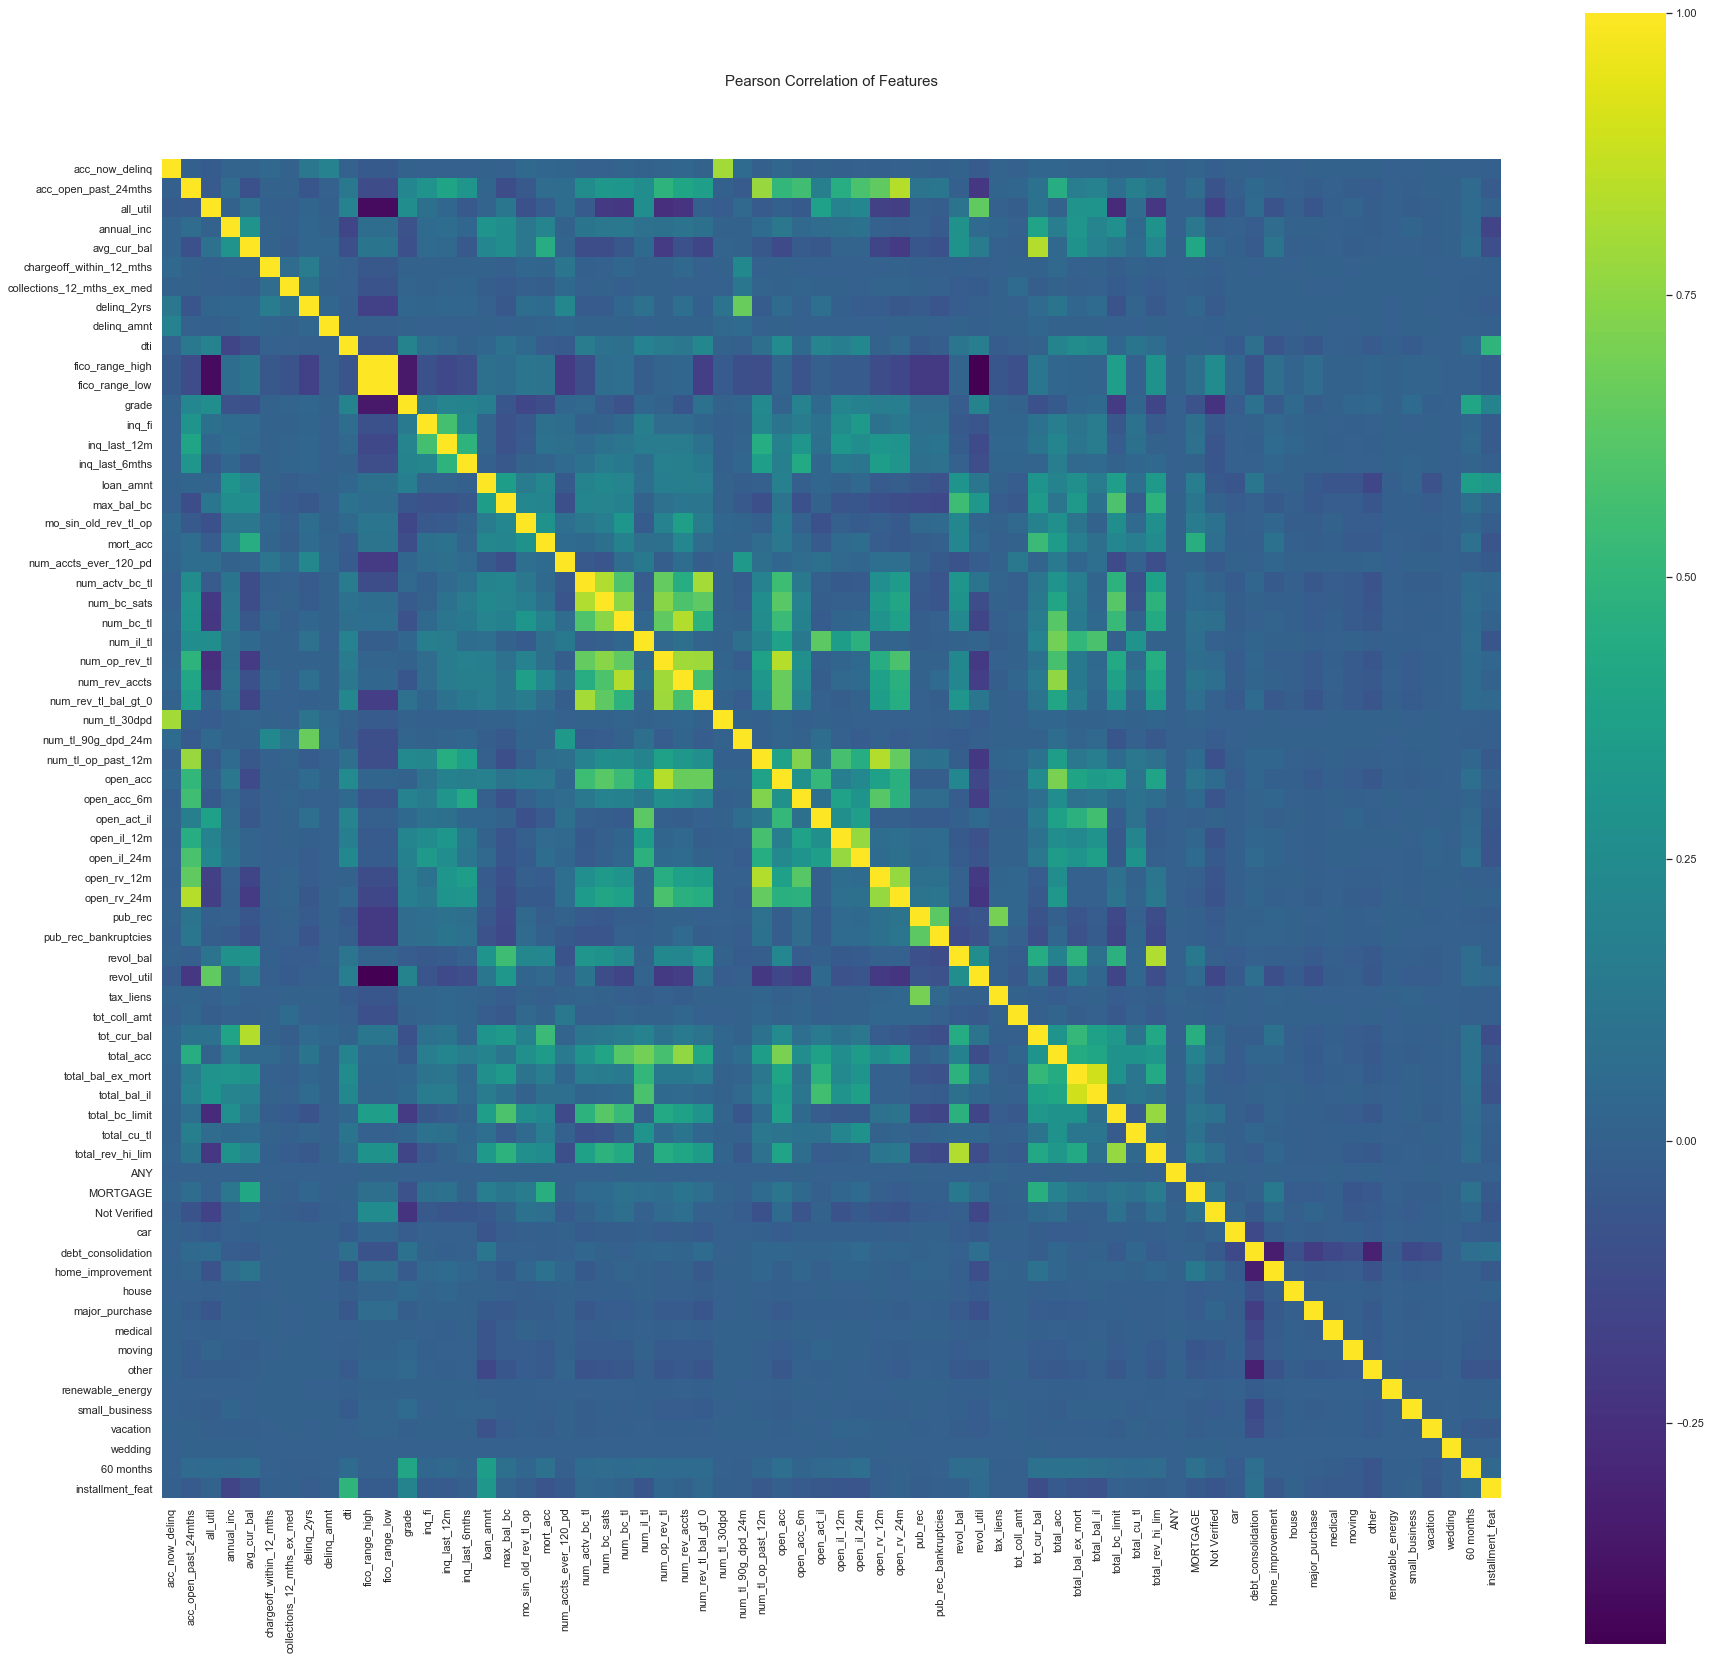

In [18]:

colormap = plt.cm.viridis
plt.figure(figsize=(30,30))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(X_train_S.corr(), square=True, cmap=colormap, linecolor='white')

In [ ]:
clf=RandomForestClassifier(n_estimators=100,random_state=123)#构建分类随机森林分类器
clf.fit(X_train_S, y_train)

In [20]:
for feature in zip(X_train_S.columns, clf.feature_importances_):
    print(feature)

('acc_now_delinq', 0.00039748844555777366)
('acc_open_past_24mths', 0.01845996185394318)
('all_util', 0.030138523756862358)
('annual_inc', 0.030867421155108803)
('avg_cur_bal', 0.03568893175356172)
('chargeoff_within_12_mths', 0.0006014844736917876)
('collections_12_mths_ex_med', 0.0013795878171723496)
('delinq_2yrs', 0.0071817100012243895)
('delinq_amnt', 0.0007036413457176676)
('dti', 0.04081588359234506)
('fico_range_high', 0.022569637673544078)
('fico_range_low', 0.022273688910038343)
('grade', 0.03544644363194513)
('inq_fi', 0.012398105634148804)
('inq_last_12m', 0.016236479056408105)
('inq_last_6mths', 0.009296965544871796)
('loan_amnt', 0.029219447039699954)
('max_bal_bc', 0.032824048128987954)
('mo_sin_old_rev_tl_op', 0.03537893436039733)
('mort_acc', 0.01420327912141063)
('num_accts_ever_120_pd', 0.008192497572132145)
('num_actv_bc_tl', 0.014785345932790373)
('num_bc_sats', 0.01537184096822739)
('num_bc_tl', 0.019358942584386234)
('num_il_tl', 0.021855640886318285)
('num_op_re

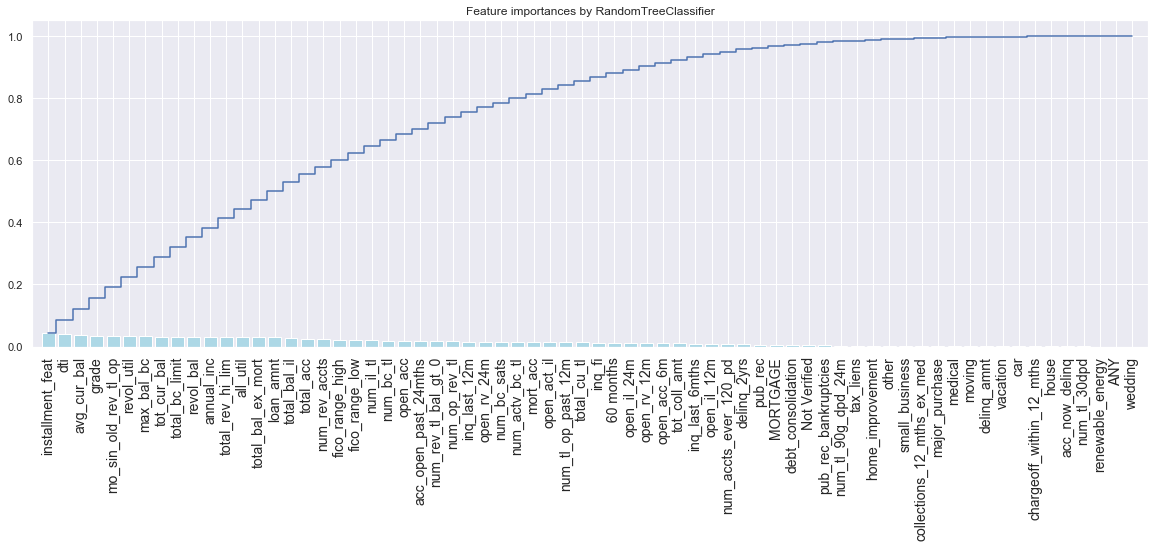

In [21]:
importances = clf.feature_importances_
feat_names = X_train_S.columns
indices = np.argsort(importances)[::-1]
fig = plt.figure(figsize=(20,6))
plt.title("Feature importances by RandomTreeClassifier")
plt.bar(range(len(indices)), importances[indices], color='lightblue',  align="center")
plt.step(range(len(indices)), np.cumsum(importances[indices]), where='mid', label='Cumulative')
plt.xticks(range(len(indices)), feat_names[indices], rotation='vertical',fontsize=14)
plt.xlim([-1, len(indices)])
plt.show()

In [22]:

y = under_sample["loan_status"]
X = under_sample.iloc[:, temp.columns != 'loan_status']
drop_col = ['installment', 'Source Verified', 'credit_card','RENT','tot_hi_cred_lim','total_il_high_credit_limit',' 36 months',
            "pct_tl_nvr_dlq",'mo_sin_rcnt_tl','mo_sin_rcnt_rev_tl_op',"OWN","num_actv_rev_tl","Verified","num_sats"]
X = X.drop(drop_col,axis = 1)


# Standardize 
#std_scaler = StandardScaler()
std_scaler = MinMaxScaler() # tried, about the same results
col = X_train.select_dtypes(include=['float64',"int64"]).columns  # scale all or only foat give same results
X_train_S = X_train.copy()
X_test_S = X_test.copy()
X_train_S[col] = std_scaler.fit_transform(X_train_S[col])
X_test_S[col] = std_scaler.transform(X_test_S[col])
#X_train_S =std_scaler.fit_transform(X_train_S)
#X_test_S =std_scaler.transform(X_test_S)

NameError: name 'under_sample' is not defined

In [23]:

Log_regression = LogisticRegressionCV(random_state=9001,penalty="l2",cv=5)
Log_regression.fit(X_train_S,y_train)
y_pred_train = Log_regression.predict(X_train_S)
y_pred_test = Log_regression.predict(X_test_S)


train_score = accuracy_score(y_train, y_pred_train)*100
test_score = accuracy_score(y_test, y_pred_test)*100
    

print("Training Set Accuracy:",str(train_score)+'%')
print("Test Set Accuracy:",str(test_score)+'%')



/Users/drawing/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/drawing/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/drawing/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/drawing/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/Users/drawing/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:757: ConvergenceWarning: lbfgs failed to converge. Increase the nu

KeyboardInterrupt: 

In [ ]:
clf=RandomForestClassifier(n_estimators=10,random_state=123)#构建分类随机森林分类器
clf.fit(X_train_S, y_train)
y_pred_test = clf.predict(X_test_S)
test_score = accuracy_score(y_test, y_pred_test)*100

In [ ]:
test_score 

In [ ]:
X[col]=std_scaler.transform(X[col])
y_pred_test = clf.predict(X)
test_score = accuracy_score(y_pred_test, y)*100

In [ ]:
test_score

In [ ]:
X.shape